<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/9_ResNetsandHigherReceptiveFields/experiments/CIFAR10_Image_Classification_CustomResnet_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary
!pip install torch-lr-finder
!pip install hiddenlayer

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-jfx5knvu
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-jfx5knvu
  Created wheel for albumentations: filename=albumentations-1.0.1-cp37-none-any.whl size=98530 sha256=212b72cb66865d5067370457a12ceabc1e3c5bc260a3fbcf1310cedb4e696e42
  Stored in directory: /tmp/pip-ephem-wheel-cache-ptsvddxi/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [ ]:
!git clone https://github.com/gkdivya/torch_cv_wrapper.git /content/drive/MyDrive/Cifar10_Resnet/session9/torch_cv_wrapper

In [ ]:
%cd "/content/drive/MyDrive/Cifar10_Resnet/session9/"
from __future__ import print_function
import torchvision
import torch
from pprint import pprint
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

## Import Custom Libraries
from torch_cv_wrapper.utils import plot_metrics,train,test,helper
from torch_cv_wrapper.utils.gradcam import generate_gradcam, plot_gradcam
from torch_cv_wrapper.model import customresnet
from torch_cv_wrapper.main import TriggerEngine

/content/drive/MyDrive/Cifar10_Resnet/session9


## Load config file

In [ ]:
config = helper.process_config("/content/drive/MyDrive/Cifar10_Resnet/session9/session9.yaml")
use_cuda = torch.cuda.is_available()
helper.set_seed(config['model_params']['seed'],use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
pprint(config)

 loading Configuration of your experiment ..
{'criterion': 'CrossEntropyLoss',
 'data_augmentation': {'type': 'CIFAR10AlbumentationS9'},
 'data_loader': {'args': {'batch_size': 512,
                          'num_workers': 2,
                          'pin_memory': True},
                 'classes': ['plane',
                             'car',
                             'bird',
                             'cat',
                             'deer',
                             'dog',
                             'frog',
                             'horse',
                             'ship',
                             'truck'],
                 'type': 'Cifar10DataLoader'},
 'lr_finder': {'lr_epochs': 25, 'max_epoch': 5},
 'lr_scheduler': 'OneCycleLR',
 'model': 'CustomResnet',
 'model_params': {'dropout': 0.05,
                  'experiment_name': 'cifar10_with_customresnet',
                  'model_dir': './model/',
                  'seed': 1},
 'optimizer': {'args': {'lr':

## Create Training Instance

In [ ]:
exp_metrics={}
experiment_name=config['model_params']['experiment_name']
trigger_training=TriggerEngine(config)

## Download data and view sample images

In [ ]:
classes= config['data_loader']['classes']

#Get dataloaders
train_loader,test_loader = trigger_training.dataloader()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


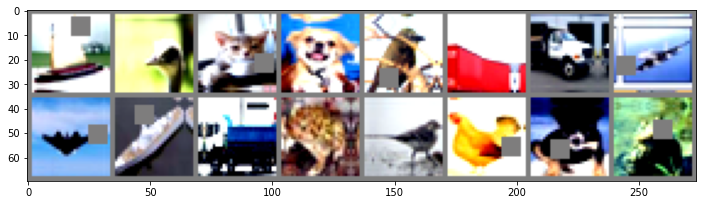

In [ ]:
# get some random training images
images, labels = iter(train_loader).next()

# # show images
helper.imshow(torchvision.utils.make_grid(images[:16]))

## Model Summary

In [ ]:
model = customresnet.CustomResNet()
model.to(device)
trigger_training.model_summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Visualize Network Architecture

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


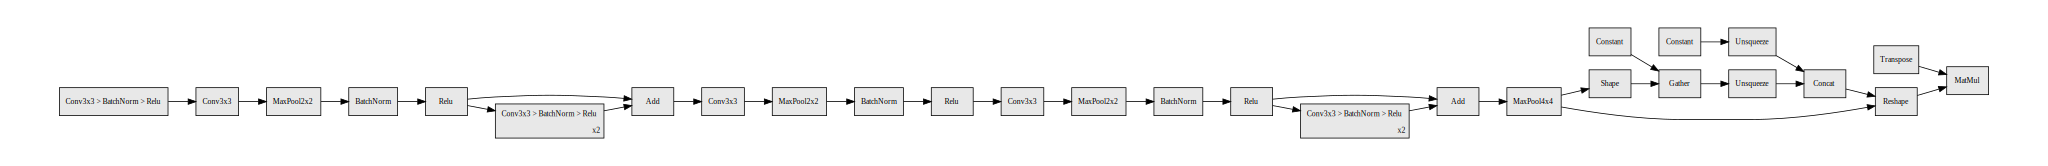

In [ ]:
import hiddenlayer as hl
input = torch.zeros([1, 3, 32, 32])
hl.build_graph(model, input.to(device))

## Find Best LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.24E-02


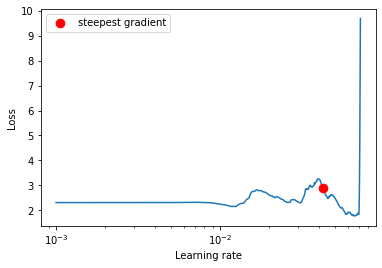

In [ ]:
start_lr = 1e-3
end_lr = 0.16
lrmax= trigger_training.find_lr(model,train_loader, test_loader, start_lr, end_lr)

## Trigger training

In [ ]:
# trigger_training.
(exp_metrics[experiment_name]) = trigger_training.run_experiment(model,train_loader,test_loader,start_lr,lrmax)

  0%|          | 0/98 [00:00<?, ?it/s]

using OneCycleLR
Epoch 1:


Loss=1.3340959548950195 Batch_id=97 LR=0.01235 Accuracy=42.91: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5432/10000 (54.32%)

Epoch 2:


Loss=1.1905055046081543 Batch_id=97 LR=0.02733 Accuracy=57.96: 100%|██████████| 98/98 [00:14<00:00,  6.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 6544/10000 (65.44%)

Epoch 3:


Loss=1.2728666067123413 Batch_id=97 LR=0.04581 Accuracy=65.85: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 6284/10000 (62.84%)

Epoch 4:


Loss=0.7469351291656494 Batch_id=97 LR=0.06071 Accuracy=71.90: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7635/10000 (76.35%)

Epoch 5:


Loss=0.49845099449157715 Batch_id=97 LR=0.06632 Accuracy=76.71: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7855/10000 (78.55%)

Epoch 6:


Loss=0.5201318264007568 Batch_id=97 LR=0.06586 Accuracy=80.47: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 7624/10000 (76.24%)

Epoch 7:


Loss=0.4184246063232422 Batch_id=97 LR=0.06452 Accuracy=83.00: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8311/10000 (83.11%)

Epoch 8:


Loss=0.47060611844062805 Batch_id=97 LR=0.06234 Accuracy=84.91: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8521/10000 (85.21%)

Epoch 9:


Loss=0.3538574278354645 Batch_id=97 LR=0.05936 Accuracy=86.31: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8473/10000 (84.73%)

Epoch 10:


Loss=0.33498820662498474 Batch_id=97 LR=0.05569 Accuracy=88.03: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8630/10000 (86.30%)

Epoch 11:


Loss=0.3784636855125427 Batch_id=97 LR=0.05140 Accuracy=88.94: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8592/10000 (85.92%)

Epoch 12:


Loss=0.2636490762233734 Batch_id=97 LR=0.04663 Accuracy=89.88: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8749/10000 (87.49%)

Epoch 13:


Loss=0.2219230979681015 Batch_id=97 LR=0.04150 Accuracy=91.12: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8812/10000 (88.12%)

Epoch 14:


Loss=0.19303517043590546 Batch_id=97 LR=0.03615 Accuracy=91.81: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8804/10000 (88.04%)

Epoch 15:


Loss=0.18487127125263214 Batch_id=97 LR=0.03073 Accuracy=92.69: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8880/10000 (88.80%)

Epoch 16:


Loss=0.18071012198925018 Batch_id=97 LR=0.02538 Accuracy=93.53: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8897/10000 (88.97%)

Epoch 17:


Loss=0.22038914263248444 Batch_id=97 LR=0.02025 Accuracy=93.84: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8971/10000 (89.71%)

Epoch 18:


Loss=0.19047854840755463 Batch_id=97 LR=0.01549 Accuracy=94.92: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9004/10000 (90.04%)

Epoch 19:


Loss=0.11469633132219315 Batch_id=97 LR=0.01122 Accuracy=95.80: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9087/10000 (90.87%)

Epoch 20:


Loss=0.12341165542602539 Batch_id=97 LR=0.00755 Accuracy=96.52: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9086/10000 (90.86%)

Epoch 21:


Loss=0.0797758623957634 Batch_id=97 LR=0.00459 Accuracy=96.95: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9139/10000 (91.39%)

Epoch 22:


Loss=0.07546330243349075 Batch_id=97 LR=0.00242 Accuracy=97.51: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9195/10000 (91.95%)

Epoch 23:


Loss=0.08678240329027176 Batch_id=97 LR=0.00110 Accuracy=97.86: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9216/10000 (92.16%)

Epoch 24:


Loss=0.08734188973903656 Batch_id=97 LR=0.00066 Accuracy=98.06: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]



Test set: Average loss: 0.0005, Accuracy: 9211/10000 (92.11%)



## Missclassification

Total wrong predictions are 789
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


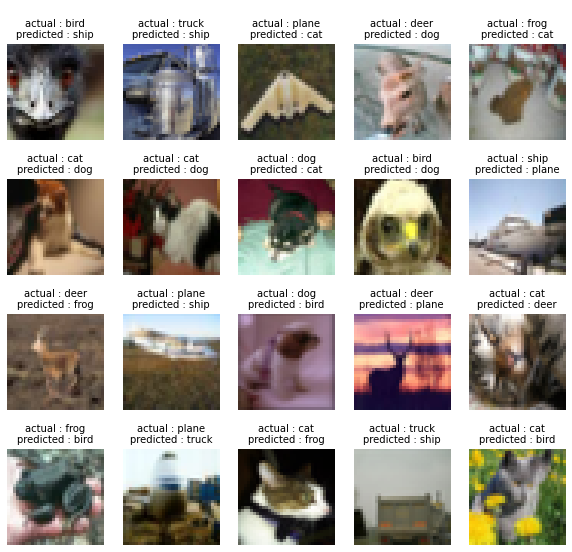

In [ ]:
misclassified_images = trigger_training.wrong_predictions(model,test_loader)

## Plots for Validation Loss and Accuracy

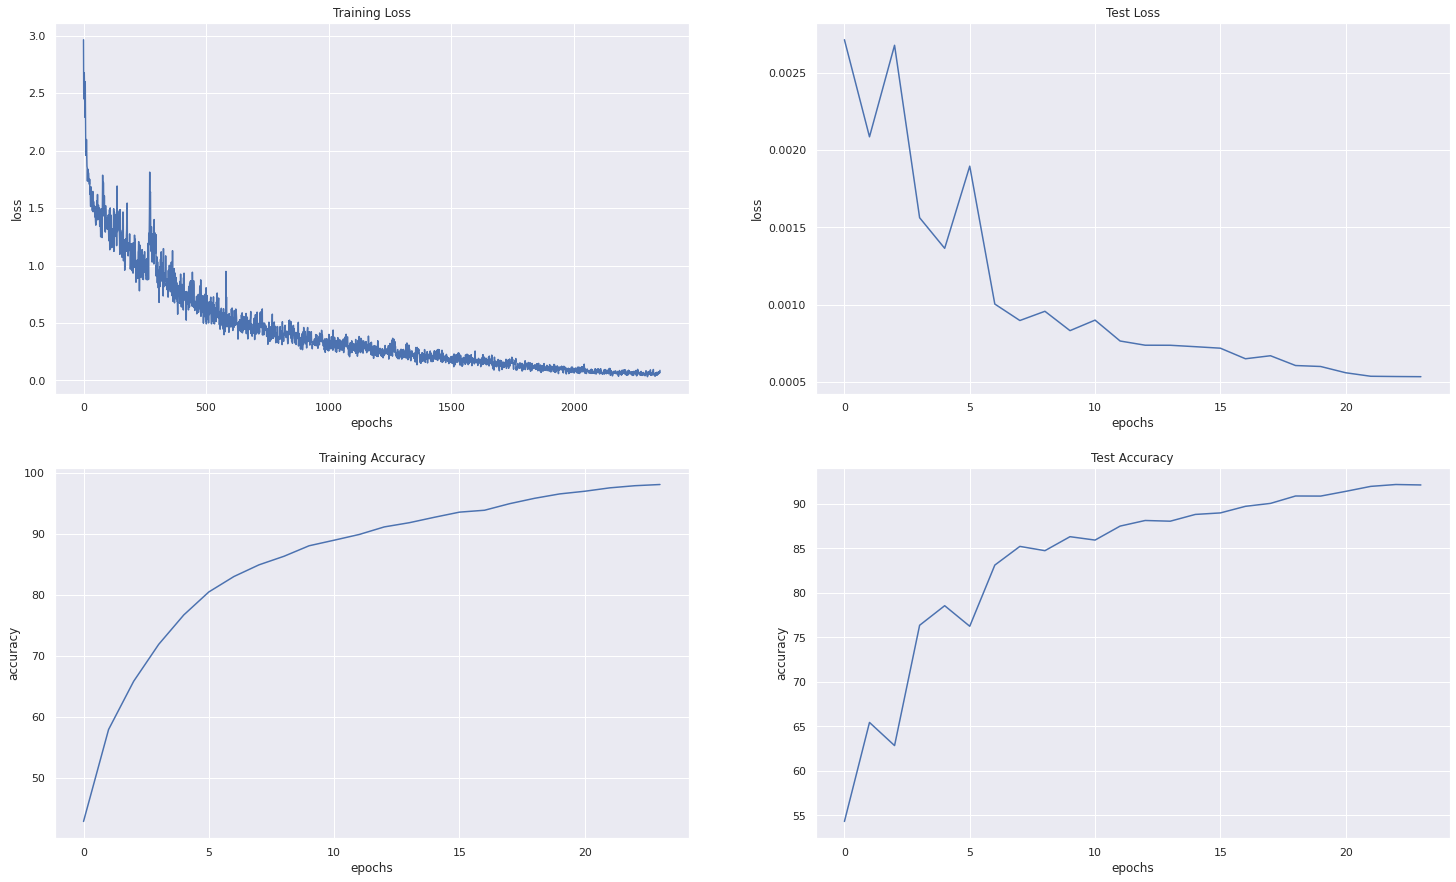

In [ ]:
plot_metrics.plot_metrics(exp_metrics[experiment_name])

## Accuracy for each class

In [ ]:
helper.class_level_accuracy(model, test_loader, device, classes)

Accuracy of plane : 92 %
Accuracy of   car : 97 %
Accuracy of  bird : 88 %
Accuracy of   cat : 80 %
Accuracy of  deer : 92 %
Accuracy of   dog : 89 %
Accuracy of  frog : 95 %
Accuracy of horse : 94 %
Accuracy of  ship : 95 %
Accuracy of truck : 95 %


## Plot Confusion Matrix

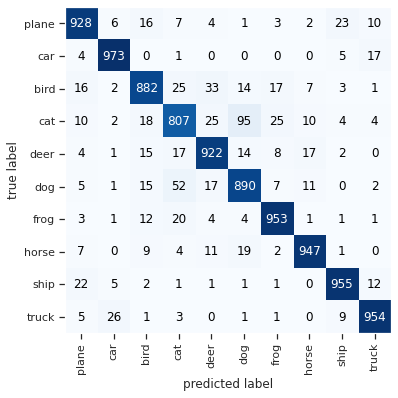

In [ ]:
mat = helper.compute_confusion_matrix(model,test_loader,device)
plot_metrics.plot_confusion_matrix(mat, class_names=classes)


## Generate & Plot GradCam Images

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


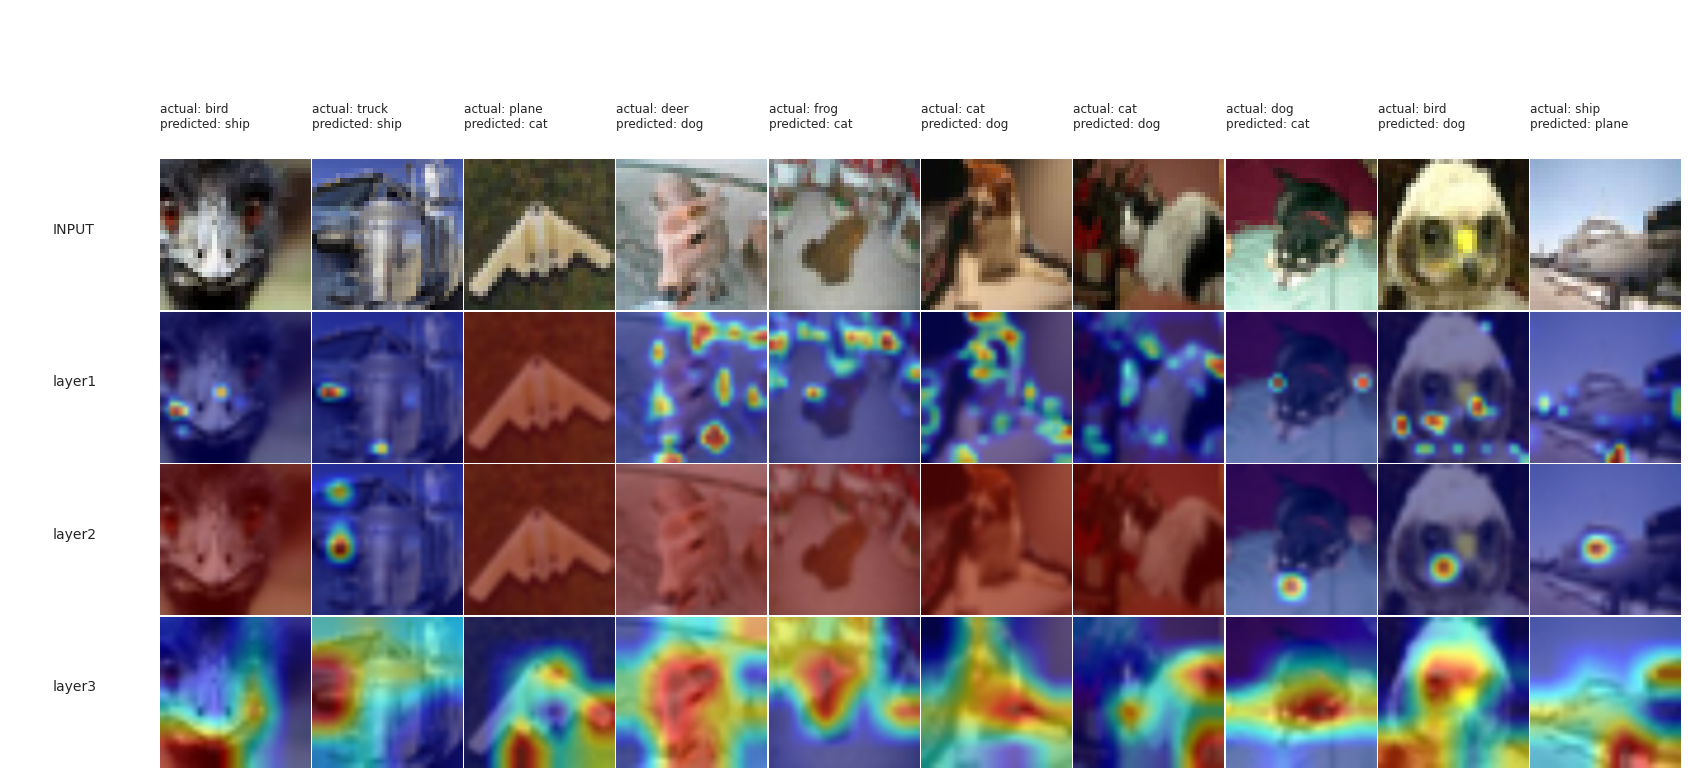

In [ ]:
target_layers = ["layer1","layer2","layer3"]
gradcam_output, probs, predicted_classes = generate_gradcam(misclassified_images[:10], model, target_layers,device)
plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:10])

In [ ]:

# %load_ext tensorboard
# %tensorboard --logdir=runs